In [1]:
import numpy as np
import pandas as pd
import folium
import branca.colormap as cm
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon
import seaborn as sns

# Import data and convert to geopandas df

In [2]:
trips = pd.read_csv('../data/processed/trips.csv')

## Create geopandas df for start locations

In [3]:
geo_trips_start = gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.start_lng, trips.start_lat)).copy()

geo_trips_start.head(2)

,bike,bike_type,identification,start_time,end_time,weekend,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,end_place,start_plz,end_plz,geometry
0,20507,29,14776184,2019-04-21 17:34:00,2019-04-21 17:47:00,1,780.0,8.884911,53.078923,8.899906,53.078711,2985.0,0.0,28329,28327,POINT (8.88491 53.07892)
1,20507,29,10278649,2019-04-23 17:55:00,2019-04-23 20:13:00,0,8280.0,8.884911,53.078923,8.884911,53.078923,2985.0,2985.0,28329,28329,POINT (8.88491 53.07892)


## Import geodata of Bremen (PLZ based)
https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/table/?refine.note=Bremen

In [4]:
plz_df = gpd.read_file('../data/external/plz_bremen.geojson')

plz_df.head(2)

,note,plz,geometry
0,Bremen,28199,"POLYGON ((8.76410 53.06703, 8.77230 53.06924, ..."
1,Bremen,28309,"POLYGON ((8.86527 53.03539, 8.86535 53.03602, ..."


## Visualization of plz areas of Bremen

Note: 28329 comprises two disjunct areas - anyway the task is to count starts and end per PLZ

In [5]:
plz_bremen = folium.Map(location=[53.113780905428636,8.72900247893676], zoom_start=11)

folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(plz_bremen)

folium.Choropleth(geo_data=plz_df).add_to(plz_bremen)

folium.LayerControl().add_to(plz_bremen)

plz_bremen

# Create new data frame with plz, the corresponding geometry and number of trips started and ended in this area

## Starts

In [6]:
def get_trips_per_plz_df(trips_df, plz_df):

    trips_df['count'] = 1

    dfsjoin = gpd.sjoin(plz_df,trips_df[['geometry','count']])

    dfpivot = pd.pivot_table(dfsjoin,index='plz',columns='count',aggfunc={'count':len})

    dfpivot.columns = dfpivot.rename(columns={1:'trips_count'}).columns.droplevel()

    trips_per_plz_df = plz_df.merge(dfpivot, how='left',on='plz')
    
    return trips_per_plz_df

In [7]:
plz_starts = get_trips_per_plz_df(geo_trips_start, plz_df)

/Users/timockenga/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [8]:
def visualize_trips_per_plz_1(plz_starts, aliases, legend_name):

    # Can be used for checking individual quantiles.
    myscale = (plz_starts['trips_count'].quantile((0,0.6,0.75,0.9,0.98,1))).tolist()

    m = folium.Map(location=[53.113780905428636,8.72900247893676], zoom_start=11)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)

    folium.Choropleth(
        geo_data=plz_starts,
        name='choropleth',
        data=plz_starts,
        columns=['plz','trips_count'],
        key_on="feature.properties.plz",
        fill_color='YlGnBu',
        #threshold_scale=myscale,
        fill_opacity=1,
        line_opacity=0.5,
        legend_name=legend_name
    ).add_to(m)

    folium.LayerControl().add_to(m)

    style_function = lambda x: {'fillColor': '#ffffff',
                                'color':'#ffffff', 
                                'fillOpacity': 0, 
                                'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.5, 
                                    'weight': 0.1}
    popup = folium.features.GeoJson(
        plz_starts,
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function, 
        tooltip=folium.features.GeoJsonTooltip(
            fields=['plz','trips_count'],
            aliases=aliases,
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
    )

    m.add_child(popup)
    m.keep_in_front(popup)

    return m

In [9]:
def visualize_trips_per_plz_2(plz_starts, aliases):

    colormap = cm.linear.YlGnBu_09.scale(0, plz_starts.trips_count.max())

    mymap = folium.Map(location=[53.113780905428636,8.72900247893676], zoom_start=11)
    
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
    
    colormap.caption = aliases[1]
    
    style_function = lambda x: {"weight":0.5, 
                                'color':'black',
                                'fillColor':colormap(x['properties']['trips_count']), 
                                'fillOpacity':1}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}
    
    trips_count=folium.features.GeoJson(
            plz_starts,
            style_function=style_function,
            control=False,
            highlight_function=highlight_function,
            tooltip=folium.features.GeoJsonTooltip(fields=['plz','trips_count'],
                aliases=aliases,
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
                sticky=True
            )
        )
    colormap.add_to(mymap)
    mymap.add_child(trips_count)
    
    return mymap

## Visualizations of starts per plz of all available data of the year 2019

In [10]:
visualize_trips_per_plz_2(plz_starts, ['Postleitzahl: ', 'Number of starts in 2019: '])

### Save to reports

In [11]:
visualize_trips_per_plz_2(plz_starts, ['Postleitzahl: ', 'Number of starts in 2019: ']).save('../reports/figures/starts_per_plz_2019.html')

- most trips in august start around the center of Bremen close to the main station

### Check the number of trips per month

Text(0.5, 1.0, 'Number of bookings per month (2019)')

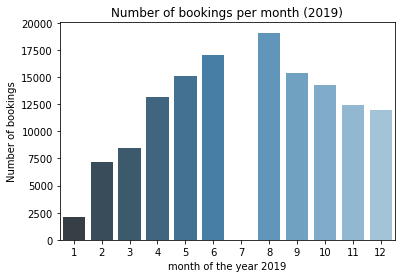

In [12]:
trips['start_time'] = pd.to_datetime(trips['start_time'])
num_trips_month = []
for i in range(1,13):
    num_trips_month.append(len(trips[trips.set_index('start_time').index.month == i]))
ax = sns.barplot(x=np.arange(1,13), y=num_trips_month, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='month of the year 2019') 
ax.set_title('Number of bookings per month (2019)')

## Visualizations of trips per plz of all available data of august 2019

In [13]:
geo_trips_start['start_time'] = pd.to_datetime(geo_trips_start['start_time'])

In [14]:
geo_trips_start_august = geo_trips_start[geo_trips_start.set_index('start_time').index.month == 8]

In [15]:
plz_starts_august = get_trips_per_plz_df(geo_trips_start_august, plz_df)

/Users/timockenga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/timockenga/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [16]:
# Replace null values with 0
plz_starts_august['trips_count'] = pd.DataFrame(plz_starts_august['trips_count']).fillna(0)

In [17]:
visualize_trips_per_plz_2(plz_starts_august,['Postleitzahl: ', 'Number of starts in august 2019: '])

- like for the whole year 2019 most trips in august start around the center of Bremen close to the main station

### Save to reports

In [18]:
visualize_trips_per_plz_2(plz_starts_august,['Postleitzahl: ', 'Number of starts in august 2019: ']).save('../reports/figures/starts_per_plz_august_2019.html')